### Imports

In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import GlorotUniform

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

image_size = (120, 160)

2025-03-14 12:01:37.873583: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 12:01:38.146515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 12:01:38.146582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 12:01:38.197318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 12:01:38.316561: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


### Read file path and labels to list

In [3]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/processed"

dataset_dir_list = [
    os.path.join(dataset_dir, folder)
    for folder in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, folder))
]

csv_path_list = [os.path.join(dir, "_labels.csv") for dir in dataset_dir_list]

csv_df = None

for csv_path in csv_path_list:
    df = pd.read_csv(csv_path, index_col="image_id")
    # undersampling
    if "oval" in csv_path:
        df = df.sample(frac=1.0, random_state=42)
    # oversampling
    elif "T_" in csv_path:
        df = df.sample(frac=1, replace=True, random_state=42)
    df.index = csv_path.split("/")[-2] + "/" + df.index
    csv_df = pd.concat([csv_df, df])

csv_df = csv_df[["angle", "left_arrow", "right_arrow"]]

display(csv_df)

,angle,left_arrow,right_arrow
image_id,,,
eight_go/1741809375879_90_35,0.5000,0.0,0.0
eight_go/1741809376915_90_35,0.5000,0.0,0.0
eight_go/1741809377983_95_35,0.5625,0.0,0.0
eight_go/1741809379015_95_35,0.5625,0.0,0.0
eight_go/1741809380047_110_35,0.7500,0.0,0.0
...,...,...,...
T_right/1741874055287_120_35,0.8750,0.0,1.0
T_right/1741873968538_105_35,0.6875,0.0,0.0
T_right/1741869071446_125_35,0.9375,0.0,1.0


In [4]:
df1 = csv_df[(csv_df["angle"] == 0.5) & (csv_df["left_arrow"] == 0.0) & (csv_df["right_arrow"] == 0.0)]
df2 = csv_df[~csv_df.index.isin(df1.index)]
df1 = df1.sample(frac=0.5, random_state=42)
new_df = pd.concat([df1, df2])
new_df = new_df.sample(frac=1, random_state=42)

df1 = new_df[(new_df["left_arrow"] == 0.0) & (new_df["right_arrow"] == 0.0)]
df2 = new_df[~new_df.index.isin(df1.index)]
df1 = df1.sample(frac=1.0, random_state=42)
new_df = pd.concat([df1, df2])
new_df = new_df.sample(frac=1, random_state=42)

csv_df = new_df

Check the data

(array([2968.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         280.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

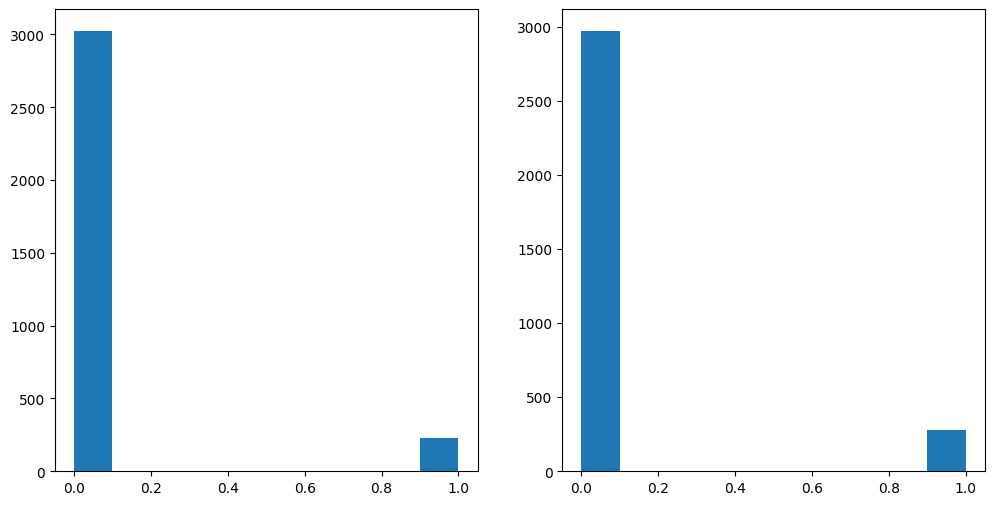

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.ravel()

ax[0].hist(csv_df["left_arrow"])
ax[1].hist(csv_df["right_arrow"])

0.00000 46
0.06250 49
0.12500 156
0.18750 178
0.25000 145
0.31250 127
0.37500 116
0.43750 341
0.50000 688
0.56250 332
0.62500 197
0.68750 363
0.75000 250
0.81250 81
0.87500 43
0.93750 70
1.00000 66
{0.0: 46, 0.0625: 49, 0.125: 156, 0.1875: 178, 0.25: 145, 0.3125: 127, 0.375: 116, 0.4375: 341, 0.5: 688, 0.5625: 332, 0.625: 197, 0.6875: 363, 0.75: 250, 0.8125: 81, 0.875: 43, 0.9375: 70, 1.0: 66}


<BarContainer object of 17 artists>

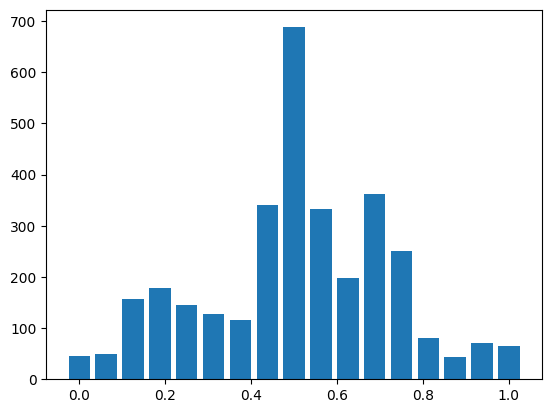

In [6]:
angle = csv_df["angle"]

df = pd.DataFrame(angle)
bins = np.unique(angle)
c = df["angle"].value_counts()

angle_count = {}

for bin in bins:
    angle_count[bin] = c[bin]

key, value = list(angle_count.keys()), list(angle_count.values())

for i in range(len(key)):
    print(f"{key[i]:.5f} {value[i]}")

print(angle_count)

plt.bar(key, value, width=0.05)

In [7]:
rs = 5695
X = np.array(csv_df.index)
y = np.array(csv_df[["angle", "left_arrow", "right_arrow"]])
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.15, random_state=rs
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=(0.15 / 0.85), random_state=rs
# )
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=rs
)

In [8]:
print(f"y_trian_left:{sum(y_train[:, 1] == 1) / len(y_train):.4f}, y_trian_right:{sum(y_train[:, 2] == 1) / len(y_train):.4f}")
print(f"y_val_left:{sum(y_val[:, 1] == 1) / len(y_val):.4f}, y_val_right:{sum(y_val[:, 2] == 1) / len(y_val):.4f}")

y_trian_left:0.0693, y_trian_right:0.0893
y_val_left:0.0708, y_val_right:0.0738


In [9]:
X_train_path = [
    os.path.join(dataset_dir, str(image_id) + ".png") for image_id in X_train
]
X_val_path = [os.path.join(dataset_dir, str(image_id) + ".png") for image_id in X_val]

In [10]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_path(file_path, labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, labels


def image_id_to_path(image_id, labels):
    image_path = tf.strings.join(
        [dataset_dir, "/", tf.as_string(image_id), ".png"]
    )  # Assuming images are .jpg
    return image_path, labels

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

2025-03-14 12:01:42.833771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


2598
650


2025-03-14 12:01:42.967725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-14 12:01:42.967769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-14 12:01:42.973361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-14 12:01:42.973400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-14 12:01:42.973421: I external/local_xla/xla/stream_executor

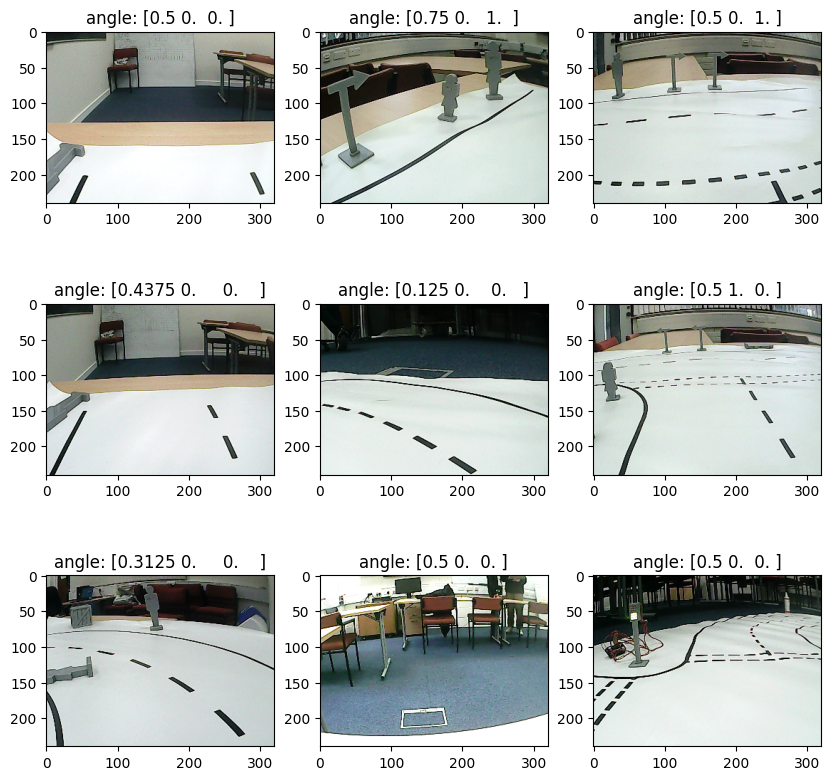

In [12]:
plt.figure(figsize=(10, 10))
i = 0

for image, labels in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    labels = labels.numpy()
    plt.title(f"angle: {labels}")
    i += 1

In [13]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [14]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, labels, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)
    image = tf.image.stateless_random_jpeg_quality(image, 80, 100, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, labels

Test augment function

20


2025-03-14 12:01:44.601065: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Augmented image shape: (240, 320, 3)


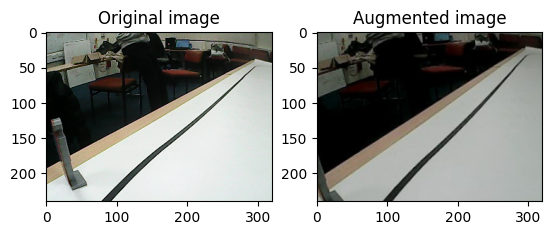

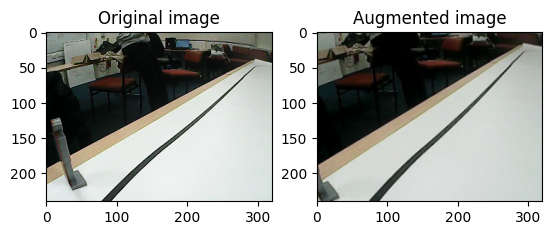

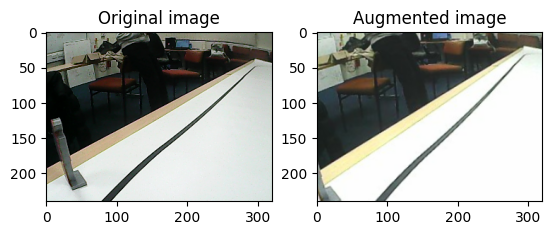

In [15]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, angle in train_ds.skip(skip).take(1):
        augmented_image, angle = augment(image, angle, None)
        visualise(image, augmented_image)

for image, angle in train_ds.take(1):
    aug_image, aug_angle = augment(image, angle)
    print(f"Augmented image shape: {aug_image.shape}")

In [16]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
def scale_ds(image, labels):
    # Range of input image: [0, 1]
    return image * 2 - 1.0, labels       # [-1, 1]
    # return image * 255, labels               # [0, 255]


train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
def resize_ds(image, labels):
    return tf.image.resize(image, [image_size[0], image_size[1]]), labels


train_ds = train_ds.map(resize_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
def rephrase_ds(image, labels):
    # return image, {"angle_output": angle}
    # angle_dict = {}
    # for i in range(10):
    #     angle_dict[f"angle{i}_output"] = angle

    return image, {"angle": labels[0], "left_arrow": labels[1], "right_arrow": labels[2]}



train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
batch_size = 32


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [23]:
total_train_sample = y_train.shape[0]

# left
num_positive = np.sum(y_train[:, 1])
weight_positive = total_train_sample / (2 * num_positive)  # Divide by 2 for balance
weight_negative = total_train_sample / (2 * (total_train_sample - num_positive))
left_weight = {0: weight_negative, 1: weight_positive}

# right
num_positive = np.sum(y_train[:, 2])
weight_positive = total_train_sample / (2 * num_positive)  # Divide by 2 for balance
weight_negative = total_train_sample / (2 * (total_train_sample - num_positive))
right_weight = {0: weight_negative, 1: weight_positive}

print(left_weight)
print(right_weight)

{0: 0.5372208436724566, 1: 7.216666666666667}
{0: 0.5490278951817413, 1: 5.599137931034483}


In [24]:
image_shape = (image_size[0], image_size[1], 3)

base_model = keras.applications.MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)
base_model.trainable = False

print(base_model.output.shape)

(None, 4, 5, 576)


In [25]:
feature_extractor = base_model.output

print(feature_extractor.shape)

a_model = []

output_activation_1 = 'sigmoid'


# model 0
i = 0

a = feature_extractor
a = layers.Conv2D(128, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f'a{i}_conv_2')(feature_extractor)
a = layers.BatchNormalization(name=f'a{i}_bn_2')(a)
a = layers.Activation('relu', name=f'a{i}_relu_2')(a)
a = layers.GlobalAveragePooling2D(name=f'a{i}_GAP')(a)
a = layers.Dense(512, activation='relu', kernel_initializer='he_uniform', name=f'a{i}_dense_2')(a)
a = layers.Dropout(0.3, name=f'a{i}_dropout_2')(a)
a = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f'a{i}_dense_1')(a)
a = layers.Dropout(0.3, name=f'a{i}_dropout')(a)

# Branch 1: Angle (regression, 0 to 1)
angle_output = layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.L2(0.01), name='angle')(a)

# Branch 2: Left Arrow (binary)
left_arrow_output = layers.Dense(1, activation='sigmoid', name='left_arrow')(a)

# Branch 3: Right Arrow (binary)
right_arrow_output = layers.Dense(1, activation='sigmoid', name='right_arrow')(a)

a_model.append(a)



# outputs_dict = {}
# loss_dict = {}
# metrics_dict = {}

# for i in range(len(a_model)):
#     outputs_dict[f'angle{i}_output'] = a_model[i]
#     loss_dict[f'angle{i}_output'] = 'mse'
#     metrics_dict[f'angle{i}_output'] = ['mae']


model = Model(inputs=base_model.input, outputs={
  "angle": angle_output,
  "left_arrow": left_arrow_output,
  "right_arrow": right_arrow_output
}, name="angle_model")

learning_rate = 0.0010

losses = {
    'angle': 'mean_squared_error',
    'left_arrow': WeightedBinaryCrossEntropy(left_weight),
    'right_arrow': WeightedBinaryCrossEntropy(right_weight)
}

loss_weights = {
    'angle': 2.0,  # Higher weight to prioritize regression
    'left_arrow': 1.0,
    'right_arrow': 1.0
}

metrics = {
    'angle': 'mse',
    'left_arrow': 'accuracy',
    'right_arrow': 'accuracy'
}

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics,
)

# model.summary()

(None, 4, 5, 576)


In [26]:
# # sub_model = Model(inputs=feature_extractor, outputs=outputs_dict, 
# #                                                     name="my_model")
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True,  # Show input/output shapes
#     show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
#     expand_nested=False,  # Keep it flat (no base_model nesting)
#     show_layer_activations=True,
#     dpi=96,  # Image resolution
# )

# print("Saved model image: model.png")

### Train model

In [27]:
NUM_OF_EPOCHS = 50

current_epoch = 1

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=f"checkpoints/model_epoch_{current_epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)

history_callback = keras.callbacks.History()

# Use this lr_schedule when re-gen data every epoch
def lr_schedule(epoch, lr):
    FIRST_N_EPOCHS = 2
    epoch = current_epoch - 1
    initial_lr = learning_rate
    if epoch < FIRST_N_EPOCHS:
        # return 0.002
        return max(initial_lr * 2, 0.002)
    # elif epoch > 46:
    #     return 0.0001
    decay = 0.42
    return initial_lr / (1 + ((epoch - FIRST_N_EPOCHS) // 3) * decay)
    # return max(initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 3) * decay), 0.0001)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

try:
    for i in range(NUM_OF_EPOCHS):
        print(f"\n{50*'*'}\nCurrent epoch: {current_epoch}", end="")

        if i == 40:
            for layer in base_model.layers[:-6]:
                layer.trainable = True
       
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath=f"checkpoints/model_epoch_{current_epoch:02d}.keras",
            save_weights_only=False,
            save_freq="epoch",
            verbose=1,
        )
        
        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=1,
            steps_per_epoch= train_ds_length // batch_size,
            validation_steps= val_ds_length // batch_size,
            callbacks=[checkpoint, history_callback, lr_scheduler],
            verbose=1,
        )

        current_epoch += 1


    # history = model.fit(
    #     train_ds,
    #     validation_data=val_ds,
    #     epochs=NUM_OF_EPOCHS,
    #     steps_per_epoch= train_ds_length // batch_size,
    #     validation_steps= val_ds_length // batch_size,
    #     callbacks=[checkpoint, history_callback, lr_scheduler],
    #     verbose=1,
    # )
except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)


**************************************************
Current epoch: 1
Epoch 1: LearningRateScheduler setting learning rate to 0.002.


2025-03-14 12:02:33.173799: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-14 12:02:33.384951: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-14 12:02:37.935594: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdd6fd9c910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-14 12:02:37.935643: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-03-14 12:02:37.948994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741953758.038596    3006 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 [==============================] - ETA: 0s - loss: 0.3316 - angle_loss: 0.0376 - left_arrow_loss: 0.1169 - right_arrow_loss: 0.1269 - angle_mse: 0.0376 - left_arrow_accuracy: 0.9560 - right_arrow_accuracy: 0.9464
Epoch 1: saving model to checkpoints/model_epoch_01.keras
81/81 [==============================] - 18s 96ms/step - loss: 0.3316 - angle_loss: 0.0376 - left_arrow_loss: 0.1169 - right_arrow_loss: 0.1269 - angle_mse: 0.0376 - left_arrow_accuracy: 0.9560 - right_arrow_accuracy: 0.9464 - val_loss: 0.1370 - val_angle_loss: 0.0148 - val_left_arrow_loss: 0.0540 - val_right_arrow_loss: 0.0454 - val_angle_mse: 0.0148 - val_left_arrow_accuracy: 0.9859 - val_right_arrow_accuracy: 0.9875 - lr: 0.0020

**************************************************
Current epoch: 2
Epoch 1: LearningRateScheduler setting learning rate to 0.002.
81/81 [==============================] - ETA: 0s - loss: 0.1365 - angle_loss: 0.0167 - left_arrow_loss: 0.0502 - right_arrow_loss: 0.0472 - angle_mse: 0.01

### Save model and plot

In [28]:
# temp = history_callback.history
# mse_dict = {}
# for key in temp.keys():
#   if key.endswith("loss"):
#     # print(f"{key}: {temp[key][-1]}")
#     mse_dict[key] = temp[key][-1]

# for i in range(int(len(mse_dict)/2)):
#   for key in mse_dict.keys():
#     if str(i) in key:
#       print(f"{key:20s}: {mse_dict[key]}")

In [29]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'angle_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

angle_loss
left_arrow_accuracy
right_arrow_accuracy


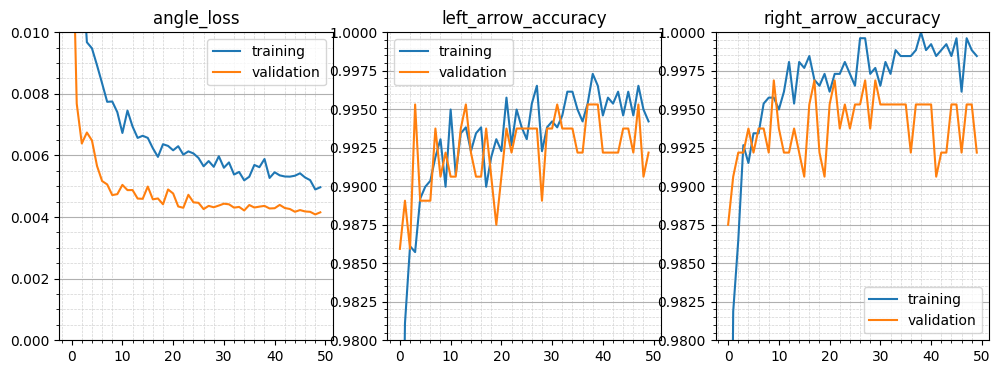

In [30]:
history = history_callback.history

wanted = ["angle_loss", "left_arrow_accuracy", "right_arrow_accuracy"]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax = ax.ravel()

for i in range(len(ax)):
    print(wanted[i])
    for key in history.keys():
        if key.endswith(wanted[i]):
            legend = "training"
            if "val" in key:
                legend = "validation"
            ax[i].plot(history[key], label=legend)
            ax[i].set_title(wanted[i])
            ax[i].legend()
            ax[i].minorticks_on()
            ax[i].grid(True, axis="y")
            ax[i].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')      

ax[0].set_ylim(0, 0.01)
ax[1].set_ylim(0.98, 1)
ax[2].set_ylim(0.98, 1)

fig.savefig(f"{folder_path}/{name_template}_performance.png")

In [31]:
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=False)

preds = model.predict(val_ds)

650/650 [==============================] - 5s 7ms/step


In [32]:
pred = np.array([preds["angle"][:, 0].T, (preds["left_arrow"][:, 0].T>0.5).astype(int), (preds["right_arrow"][:, 0].T>0.5).astype(int)]).T

5 645 49 46


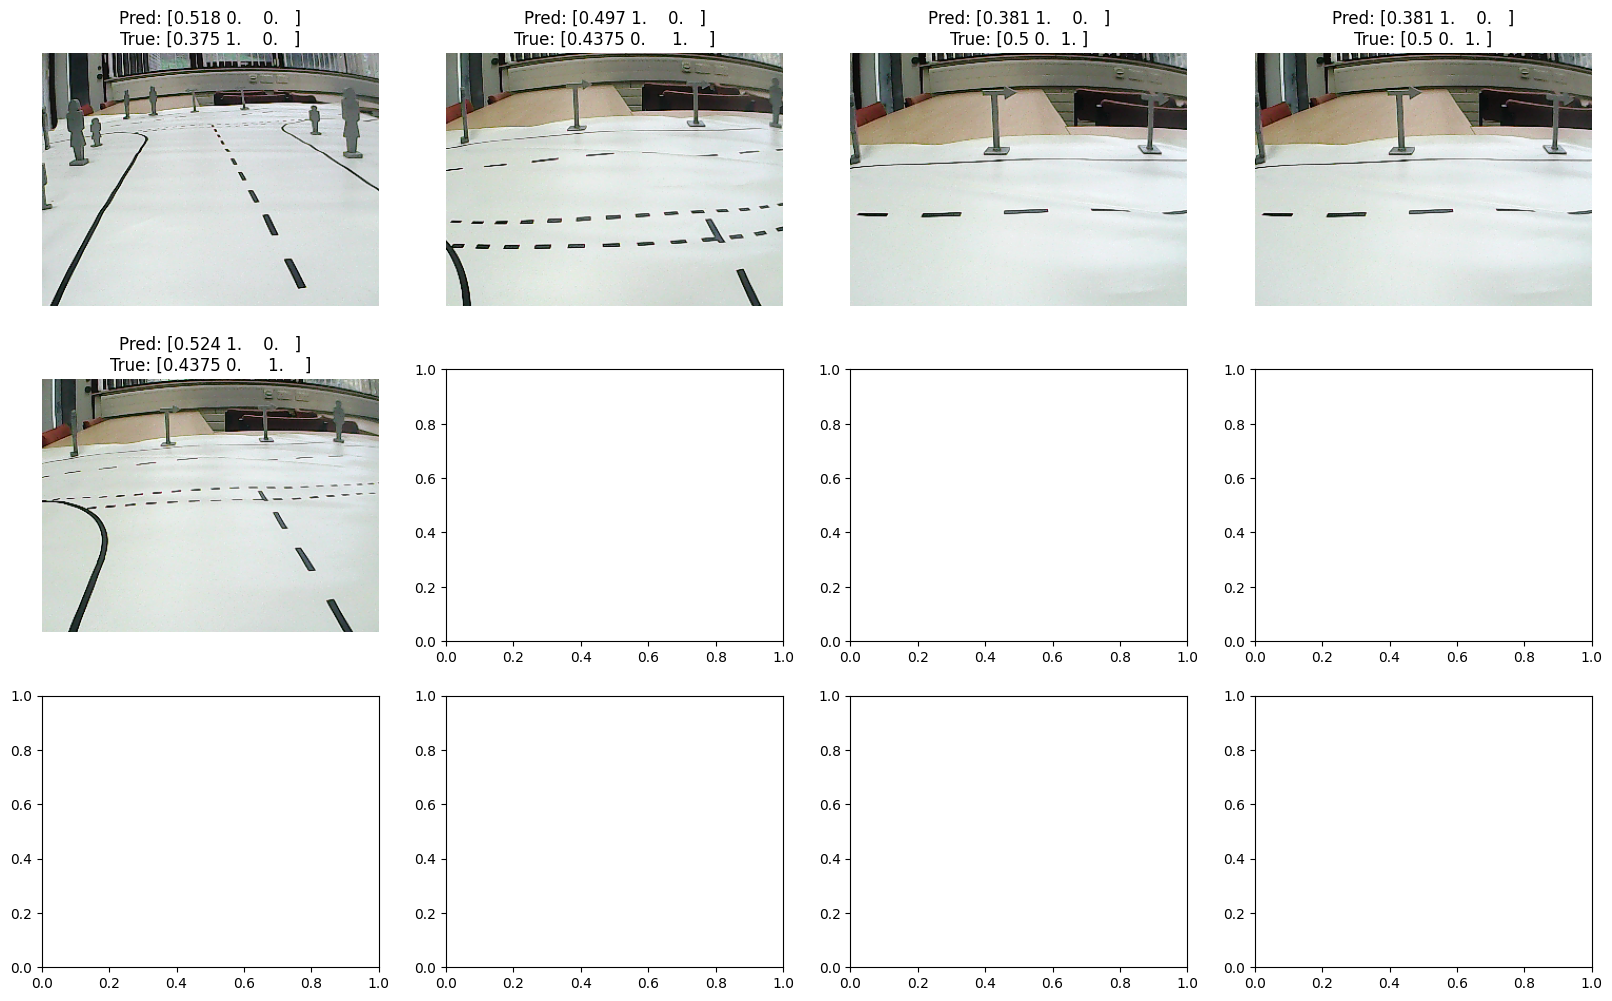

In [33]:
fig, ax = plt.subplots(3, 4, figsize=(20, 12))
ax = ax.ravel()

image_count = 0

i = 1
print(np.sum(pred[:, i] != y_val[:, i]), np.sum(pred[:, i] == y_val[:, i]), np.sum(pred[:, i] == 1), np.sum(y_val[:, i] == 1))

for i in range(len(pred)):
    if pred[i][1] != y_val[i][1]:
        image = Image.open(X_val_path[i])
        ax[image_count].imshow(image)
        ax[image_count].set_title(f"Pred: {np.round(pred[i], 3)}\nTrue: {y_val[i]}")
        ax[image_count].axis("off")
        image_count += 1
        # print(f"{i}: {pred[i]} | {true_val[i]}")

5 645 45 48


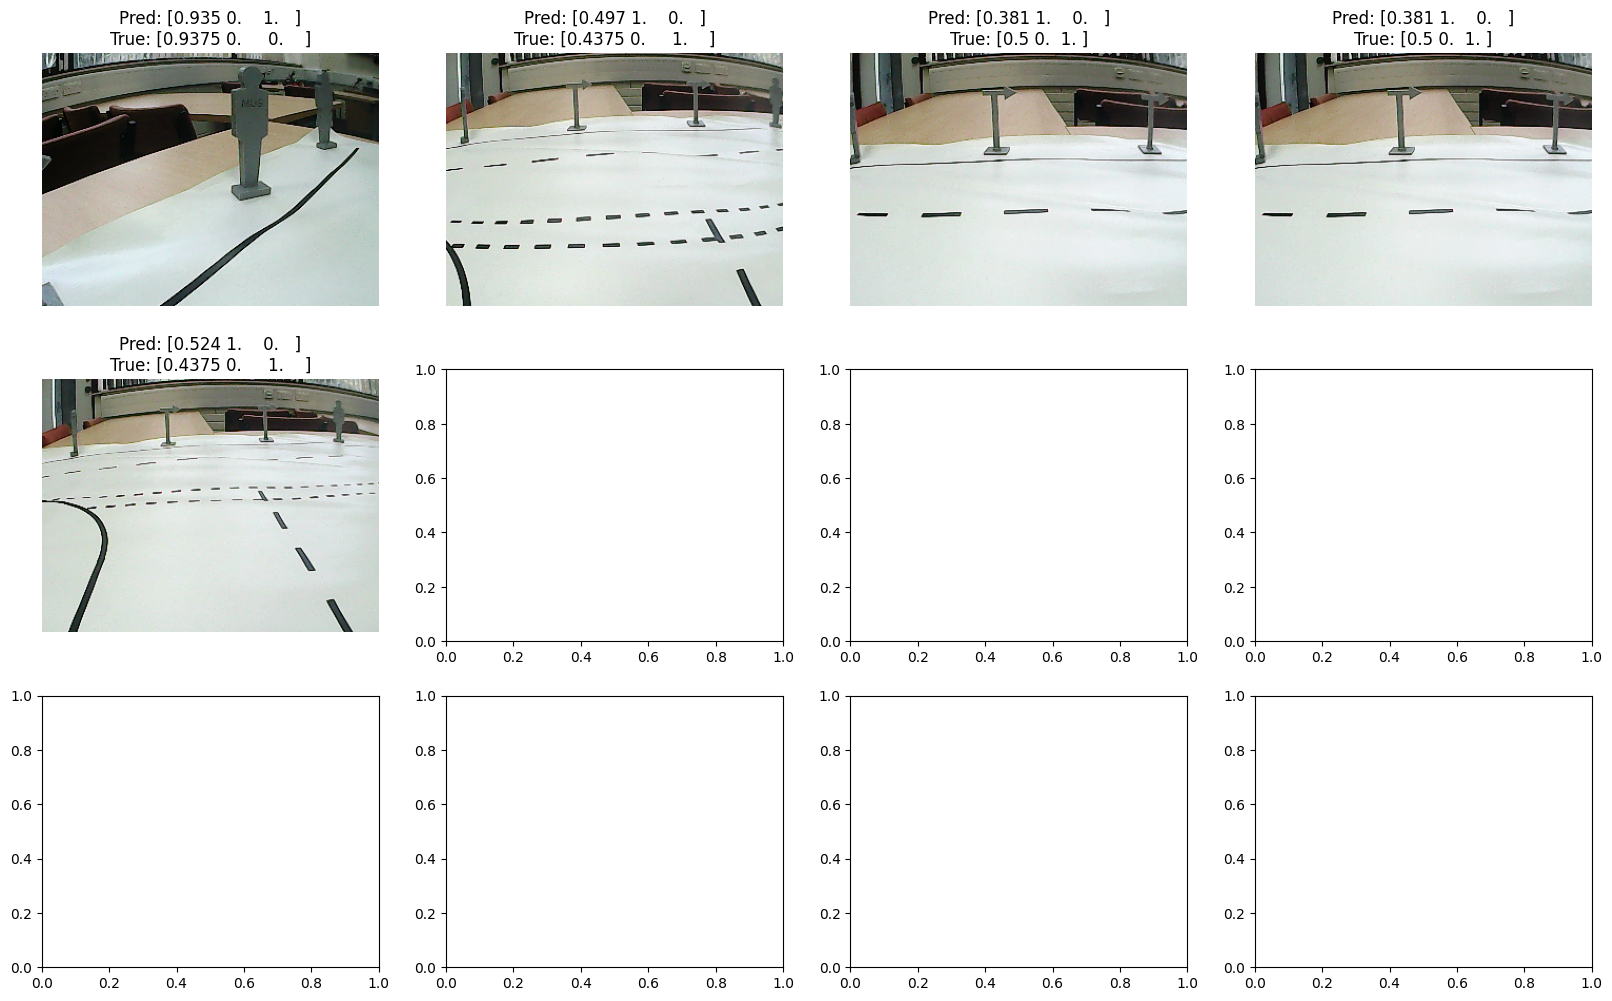

In [34]:
fig, ax = plt.subplots(3, 4, figsize=(20, 12))
ax = ax.ravel()

image_count = 0

i = 2
print(np.sum(pred[:, i] != y_val[:, i]), np.sum(pred[:, i] == y_val[:, i]), np.sum(pred[:, i] == 1), np.sum(y_val[:, i] == 1))

for i in range(len(pred)):
    if pred[i][2] != y_val[i][2]:
        image = Image.open(X_val_path[i])
        ax[image_count].imshow(image)
        ax[image_count].set_title(f"Pred: {np.round(pred[i], 3)}\nTrue: {y_val[i]}")
        ax[image_count].axis("off")
        image_count += 1
        # print(f"{i}: {pred[i]} | {true_val[i]}")

RAW MSE: 0.0041938439557138284


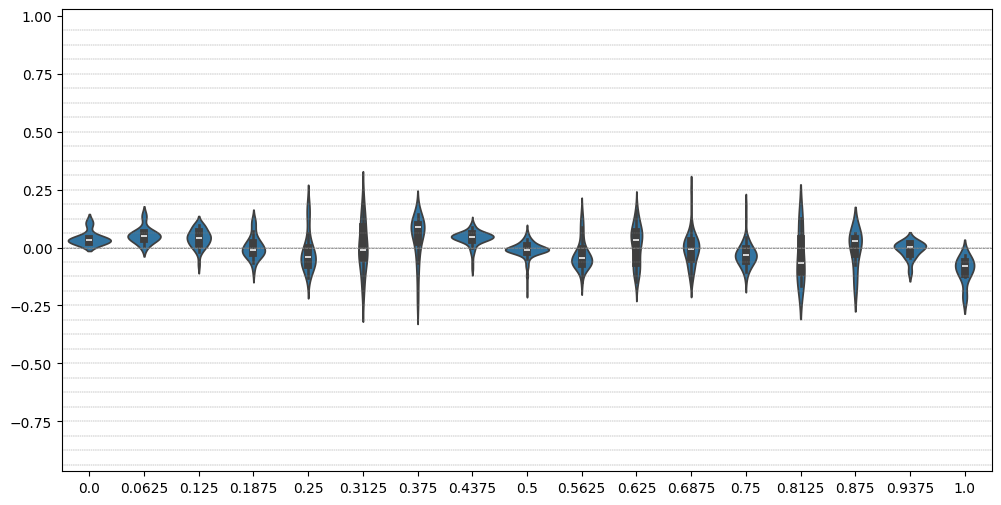

In [35]:
print(f"RAW MSE: {np.mean(np.square(pred[:, 0] - y_val[:, 0]))}")

diff_dict = {}

for key in np.unique(y_val):
    diff_dict[key] = []

for i in range(len(y_val)):
    diff_dict[y_val[i][0]].append((pred[i][0] - y_val[i][0]))

# Flatten the dictionary into two lists
x_labels = []  # Categories (keys)
y_values = []  # Values (list elements)

for key, values in diff_dict.items():
    x_labels.extend([key] * len(values))
    y_values.extend(values)

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x=x_labels, y=y_values)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.5)
ii = 0
while ii < 1:
    plt.axhline(y=ii, linestyle='--', color='gray', linewidth=0.3)
    plt.axhline(y=-ii, linestyle='--', color='gray', linewidth=0.3)
    ii += 0.0625

In [36]:
# dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025"
# training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")
# csv_path = os.path.join(dataset_dir, "training_norm.csv")

# csv_df = pd.read_csv(csv_path, index_col="image_id")
# csv_df.loc[csv_df["speed"] > 1, "speed"] = 1
# csv_df.drop(columns=["speed"], inplace=True)

# X = np.array(csv_df.index)
# y = np.array(csv_df["angle"])

# _, X_val_provided, _, y_val_provided = train_test_split(
#     X, y, test_size=0.2
# )

# X_val_provided_path = [
#     os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val_provided
# ]

# val_ds = tf.data.Dataset.from_tensor_slices((X_val_provided_path, y_val_provided))
# val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(resize_ds, num_parallel_calls=tf.data.AUTOTUNE)
# # val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = configure_for_performance(val_ds, shuffle=False, batch=False)

# pred_provided = model.predict(val_ds)

In [37]:
y_val_provided
angle_pred = pred_provided['angle'][:, 0]
np.mean((angle_pred - y_val_provided)**2)


NameError: name 'y_val_provided' is not defined

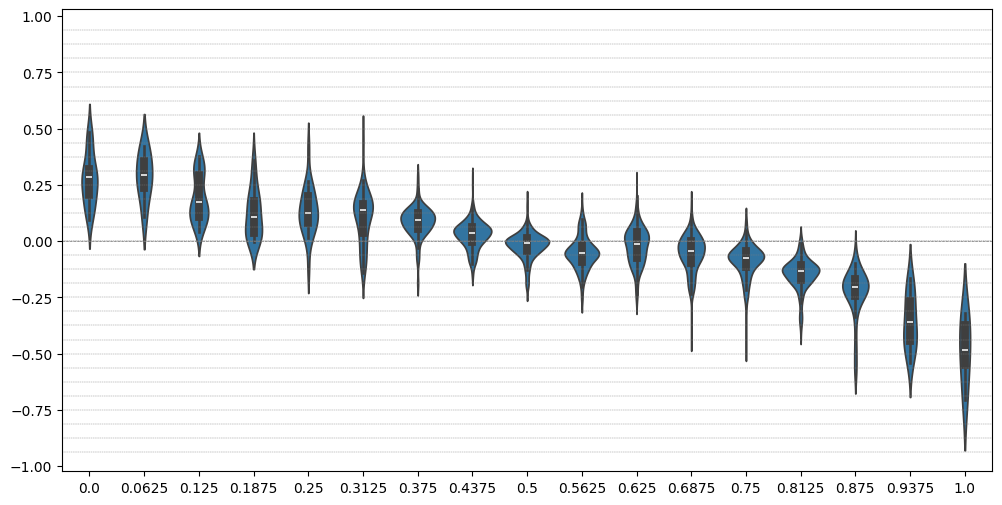

In [ ]:
diff_dict = {}

for key in np.unique(y_val_provided):
    diff_dict[key] = []

for i in range(len(y_val_provided)):
    diff_dict[y_val_provided[i]].append((angle_pred[i] - y_val_provided[i]))

# Flatten the dictionary into two lists
x_labels = []  # Categories (keys)
y_values = []  # Values (list elements)

for key, values in diff_dict.items():
    x_labels.extend([key] * len(values))
    y_values.extend(values)

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x=x_labels, y=y_values)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.5)
ii = 0
while ii < 1:
    plt.axhline(y=ii, linestyle='--', color='gray', linewidth=0.3)
    plt.axhline(y=-ii, linestyle='--', color='gray', linewidth=0.3)
    ii += 0.0625

In [ ]:
y_pred = []
for key in pred.keys():
    print(key, end=", ")
    temp = (pred[key][:, 0])
    y_pred.append(temp)

y_pred_mean = np.mean(y_pred, axis=0)

y_pred.append(y_pred_mean)

y_pred = np.array(y_pred)

y_pred = np.where(np.abs(y_pred - 0.5) < 0.1, y_pred, (y_pred - 0.5) * 1.1 + 0.5)

y_pred_ae = y_pred - y_val

diff_dict_list = []
for i in range(len(y_pred)):
    diff_dict = {}

    for key in np.unique(y_val):
        diff_dict[key] = []

    for y_true, y_error in zip(y_val, np.array(y_pred_ae[i, :])):
        diff_dict[y_true].append(y_error)

    diff_dict_list.append(diff_dict)




df = pd.DataFrame([
    (group_idx, k, v) 
    for group_idx, diff_dict in enumerate(diff_dict_list) 
    for k, vals in diff_dict.items() 
    for v in vals
], columns=['Group', 'Key', 'Value'])


ranges = [
    (float('-inf'), 0.25, 'Keys < 0.25'),
    (0.25, 0.5, '0.25 <= Keys < 0.5'),
    (0.5, 0.75, '0.5 <= Keys < 0.75'),
    (0.75, float('inf'), 'Keys >= 0.75')
]

# Create figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharey=True)

# Loop over ranges and plot
for i, (lower, upper, title) in enumerate(ranges):
    # Filter DataFrame for this range
    df_subset = df[(df['Key'] >= lower) & (df['Key'] < upper)]
    
    # Plot violin
    sns.violinplot(x='Key', y='Value', hue='Group', data=df_subset, ax=axes[i], 
                   palette='muted', linewidth=0.7)
    
    # Customize
    axes[i].set_ylim(-0.5, 0.5)
    axes[i].set_xlabel('Key')
    axes[i].set_ylabel('Value')
    axes[i].axhline(y=0, linestyle='--', color='gray', linewidth=0.5)
    ii = 0
    while ii < 0.5:
        axes[i].axhline(y=ii, linestyle='--', color='gray', linewidth=0.3)
        axes[i].axhline(y=-ii, linestyle='--', color='gray', linewidth=0.3)
        ii += 0.0625
    # Make legend horizontal
    axes[i].legend(loc='upper center', ncol=len(df['Group'].unique()), 
                   bbox_to_anchor=(0.5, 1.15), frameon=False)
# Adjust layout
plt.tight_layout()

plt.show()


fig.savefig(f"{folder_path}/{name_template}_distribution.png")

print(np.mean((y_pred[-1]-y_val)**2))

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
train_ds = train_ds.map(image_id_to_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = configure_for_performance(train_ds, shuffle=False, batch=False)

train_pred = model.predict(train_ds)

11724/11724 [==============================] - 148s 13ms/step


angle0_output, angle1_output, angle2_output, angle3_output, angle4_output, angle5_output, angle6_output, angle7_output, angle8_output, angle9_output, 

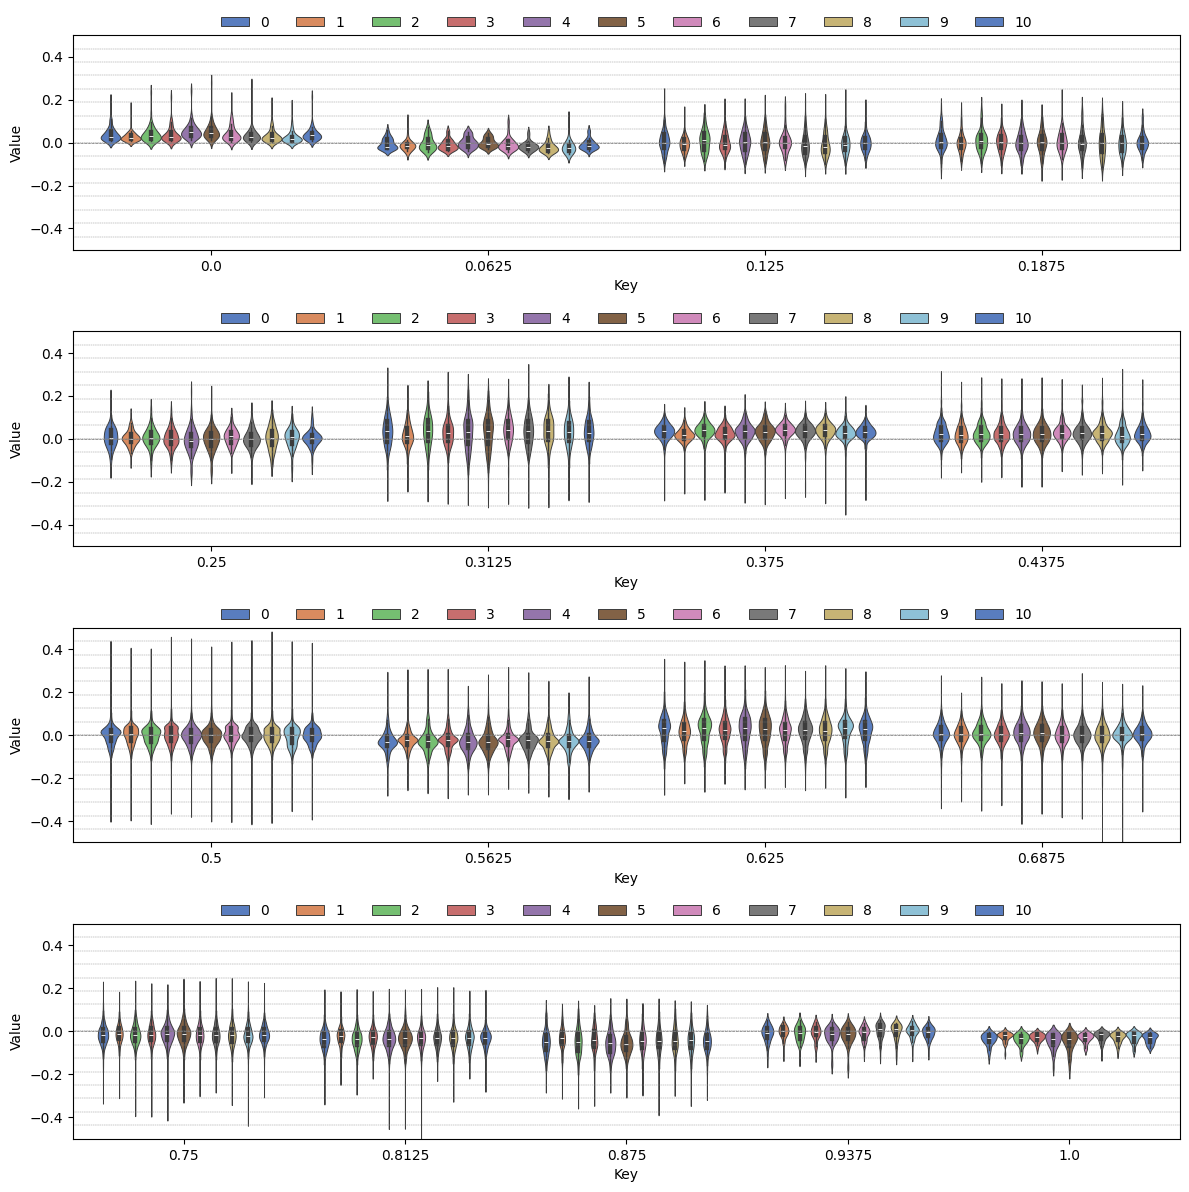

0.0027165073410871433


In [ ]:
y_pred = []
for key in train_pred.keys():
    print(key, end=", ")
    temp = (train_pred[key][:, 0])
    y_pred.append(temp)

y_pred_mean = np.mean(y_pred, axis=0)

y_pred.append(y_pred_mean)

y_pred = np.array(y_pred)

# y_pred = np.clip(y_pred, 0, 1)

# y_pred = y_pred + np.sign(y_pred - 0.5) * abs(y_pred - 0.5) * 0.3

y_pred_ae = y_pred - y_train

diff_dict_list = []
for i in range(len(y_pred)):
    diff_dict = {}

    for key in np.unique(y_train):
        diff_dict[key] = []

    for y_true, y_error in zip(y_train, np.array(y_pred_ae[i, :])):
        diff_dict[y_true].append(y_error)

    diff_dict_list.append(diff_dict)




df = pd.DataFrame([
    (group_idx, k, v) 
    for group_idx, diff_dict in enumerate(diff_dict_list) 
    for k, vals in diff_dict.items() 
    for v in vals
], columns=['Group', 'Key', 'Value'])


ranges = [
    (float('-inf'), 0.25, 'Keys < 0.25'),
    (0.25, 0.5, '0.25 <= Keys < 0.5'),
    (0.5, 0.75, '0.5 <= Keys < 0.75'),
    (0.75, float('inf'), 'Keys >= 0.75')
]

# Create figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharey=True)

# Loop over ranges and plot
for i, (lower, upper, title) in enumerate(ranges):
    # Filter DataFrame for this range
    df_subset = df[(df['Key'] >= lower) & (df['Key'] < upper)]
    
    # Plot violin
    sns.violinplot(x='Key', y='Value', hue='Group', data=df_subset, ax=axes[i], 
                   palette='muted', linewidth=0.7)
    
    # Customize
    axes[i].set_ylim(-0.5, 0.5)
    axes[i].set_xlabel('Key')
    axes[i].set_ylabel('Value')
    axes[i].axhline(y=0, linestyle='--', color='gray', linewidth=0.5)
    ii = 0
    while ii < 0.5:
        axes[i].axhline(y=ii, linestyle='--', color='gray', linewidth=0.3)
        axes[i].axhline(y=-ii, linestyle='--', color='gray', linewidth=0.3)
        ii += 0.0625
    # Make legend horizontal
    axes[i].legend(loc='upper center', ncol=len(df['Group'].unique()), 
                   bbox_to_anchor=(0.5, 1.15), frameon=False)
# Adjust layout
plt.tight_layout()

plt.show()


fig.savefig(f"{folder_path}/{name_template}_train_distribution.png")

print(np.mean((y_pred[-1]-y_train)**2))